In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy
import umap
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial import Voronoi, voronoi_plot_2d

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs, permutation_test
from models import JacobianCI, JitterCI
from plotting_functions import scatter3d, set_size, colorbar_axis
from utils import rotation_matrix

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
savefigs = False
dpi=150

In [4]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    metric_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    G_history = []
    for epoch in tqdm.trange(5000):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        metric = model.CI_metric(r=rs).item()
        G_history.append(model.metric_tensor(model.jacobian(rs)).detach().numpy())
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
        metric_history.append(metric)
    phases_history[-1] = model.unit_cell.wrap(phases_history[-1])
    loss_history = np.array(loss_history)
    metric_history = np.array(metric_history)
    phases_history = np.array(phases_history)
    G_history = np.array(G_history)
    return loss_history, phases_history, metric_history, G_history

def hex_radius(phases, model):
    cdists = np.stack([model.unit_cell.geodesic(phases[i:i+1],phases) for i in range(len(phases))])
    off_diag_mask = ~np.eye(cdists.shape[0],dtype=bool)
    return np.mean(cdists[off_diag_mask]), np.std(cdists[off_diag_mask])

def hex_orientation(phases, model, degrees=True):
    # mirror x and y since arctan2 takes y as first argument and x as second
    angles = np.stack([np.arctan2(*(model.unit_cell.wrap(phases - phases[i]))[:,::-1].T) 
                       for i in range(len(phases))])
    # modulo 60 degrees
    angles = angles % (np.pi/3)
    angles = angles * 180/np.pi if degrees else angles
    off_diag_mask = ~np.eye(phases.shape[0],dtype=bool)
    return np.mean(angles[off_diag_mask]), np.std(angles[off_diag_mask]) 

In [5]:
# load trained model
dtype = torch.float32
# choose seed such that metagon is contained in zero-centered unit cell
model = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
loss_history, phases_history, metric_history, G_history = train_model(model)

100%|██████████| 5000/5000 [00:10<00:00, 479.91it/s]


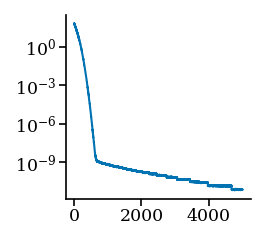

In [6]:
plt.semilogy(loss_history)

In [47]:

phases = phases_history[-1]
sort_idxs = np.argsort(np.linalg.norm(phases,axis=1))
np.linalg.norm(phases[sort_idxs][1:] - phases[sort_idxs][0],axis=1)

array([0.43643574, 0.43643577, 0.43643581, 0.43643577, 0.43643574,
       0.43643578])

In [48]:
2/np.sqrt(21)

0.4364357804719848

In [19]:
phases_history_short = phases_history[::25]
phases_history_short = np.array([model.unit_cell.wrap(phases_history_short[i]) for i in range(len(phases_history_short))])

radius, _ = hex_radius(phases_history[-1],model)
orientation, _ = hex_orientation(phases_history[-1],model)
center = np.mean(phases_history[-1],axis=0)
metagon = Hexagon(radius, orientation, center)
orientation

10.893394649130872

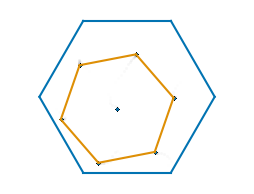

In [29]:
figsize = set_size(fraction=(1/3,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize)#,dpi=300)

N = len(phases_history_short)
[ax.scatter(*phases_history_short[i].T,color='black',alpha=(i+0.7)/(N+0.7)) for i in range(N)]
ax.scatter(*phases_history[-1].T)
model.unit_cell.plot(fig,ax,color=color_cycler[0])
metagon.plot(fig,ax,color=color_cycler[1])

ax.axis('off')
ax.axis('equal')
#padding = 0.0
#ax.set_position([-padding, -padding, 1+padding, 1+padding])
fig.tight_layout(pad=0.35, h_pad=0, w_pad=0)

if savefigs:
    fig.savefig('../results/P3-optimal-7phases')

In [9]:
t_mesh = torch.tensor(model.unit_cell.mesh(100),dtype=torch.float32)
activity = model(t_mesh).detach().numpy()
dists = np.log(np.sum(activity**2,axis=-1))
dists = dists - np.mean(dists) # shift to zero: basically display residual distances to minimum
print(np.min(dists),np.max(dists))
print(np.mean(dists),np.std(dists))

-4.4703484e-07 3.874302e-07
-8.362532e-09 1.0131064e-07


In [47]:
t_mesh = torch.tensor(model.unit_cell.mesh(100),dtype=torch.float32)
activity = model(t_mesh).detach().numpy()
dists = np.linalg.norm(activity, axis=-1)#np.sum(activity**2,axis=-1)
#dists = dists - np.mean(dists) # shift to zero: basically display residual distances to minimum
print(np.min(dists),np.max(dists))
print(np.mean(dists),np.std(dists))

1.1385498 1.1385503
1.13855 9.973052e-08


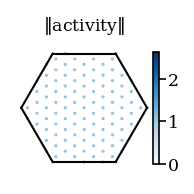

In [43]:
fig, ax = plt.subplots(figsize=set_size(fraction=(1/4,1/4),mode='square'))

model.unit_cell.plot(fig,ax,color='black')
im = ax.scatter(*t_mesh.T,c=dists, vmin=0, vmax=np.sqrt(7))
ax.axis('equal')
ax.axis('off')
cbar = plt.colorbar(im, ax=ax, fraction=0.039, pad=0)
#x, y = cbar.ax.yaxis.get_offset_text().get_position()
#cbar.ax.yaxis.get_offset_text().set_position((x+2, y))
ax.set_title(r'$\|$' + 'activity' + r'$\|$', fontsize='small', pad=0)
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)
#ax.set_title('$\| \underline{g} \|$', fontsize='small')
#ax.set_title('$\\| \\underline{g} \\|$', fontsize='small')
if savefigs:
    fig.savefig('../results/P3-activity-norm')

In [62]:
random_metagons.shape

(105, 2)

In [139]:
import copy 
model2 = copy.deepcopy(model)

random_metagons = model2.phases.detach().numpy()[:,None] + metagon.sample(15)[None]
#random_metagons = metagon.sample(7*15)[None]
random_metagons = random_metagons.reshape(-1,2)
random_metagons = model2.unit_cell.wrap(random_metagons)
model2.set_phases(random_metagons)
model2.set_scale() # reset the CI scale now that there are more neurons in the module

Parameter containing:
tensor(153.5272, requires_grad=True)

0.30646905292241006


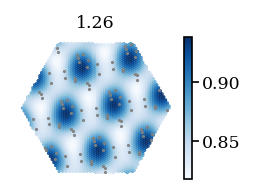

In [141]:
fig, ax = plt.subplots(figsize=set_size(fraction=(1/3,1/4),mode='square'))
# KDE
kde, mesh = model2.phase_kde(bw_method=0.1)[:2]
kde = kde / (np.sum(kde) * model.unit_cell.area / len(kde)) # normalize to unit integral
im = ax.scatter(*mesh.T,c=kde)
ax.set_title(np.around(model2.grid_score(bw_method=0.2),2),fontsize='small')

#model.unit_cell.plot(fig,ax,color='black')
#metagon.plot(fig,ax,color=color_cycler[1])
ax.scatter(*random_metagons.T, color='grey')
ax.axis('off')
ax.axis('equal')

# add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(im, cax=cax, orientation='vertical')

# print standard deviation of the KDE
print(np.std(10*kde))

fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)
if savefigs:
    fig.savefig('../results/P3-metagon-kde')

In [118]:
kde, np.mean(kde)

(array([0.95888961, 0.94592028, 0.92935776, ..., 0.97195193, 0.97145951,
        0.96573175]),
 0.8660254037844388)

In [119]:
(np.sum(kde) * model.unit_cell.area / len(kde))

1.0000000000000002

In [35]:
model.unit_cell.area, kde.shape

(1.1547005383792515, (4096,))

In [37]:
# integrate the KDE
integral = np.sum(kde) * model.unit_cell.area / kde.shape[0]
integral

0.05263157894735137

In [40]:
mesh.shape

(4096, 2)

In [41]:
# numerically integrate the KDE with scipy on the 2D mesh
integral = scipy.integrate.simps(kde, x=mesh[:,0], axis=0)
print(integral)
integral = scipy.integrate.simps(integral, x=mesh[:,1], axis=0)
integral *= model.unit_cell.area / kde.shape[0]
integral

2364801373.8659935


IndexError: tuple index out of range

In [24]:
np.sum(kde)

186.69684494210645

In [14]:
mesh = model.unit_cell.mesh(100)
model2.CI_metric(r=mesh), model.CI_metric(r=mesh), 

(tensor(3.3206e-09, grad_fn=<AddBackward0>),
 tensor(6.4795e-12, grad_fn=<AddBackward0>))

In [15]:
model.loss_fn(t_mesh).item(), model2.loss_fn(t_mesh).item()

(8.969009562820318e-12, 1.578033925753175e-09)

In [16]:
7.103386889112384e-12 * 2

1.4206773778224768e-11

In [17]:
X = np.random.uniform(size=(4,4))

In [18]:
X.T @ X

array([[1.48670042, 0.7458758 , 0.35643402, 1.80629005],
       [0.7458758 , 1.0868435 , 0.58075085, 1.28731984],
       [0.35643402, 0.58075085, 0.37490349, 0.69336868],
       [1.80629005, 1.28731984, 0.69336868, 2.44234677]])

In [19]:
X[:2].T @ X[:2] + X[2:].T @ X[2:]

array([[1.48670042, 0.7458758 , 0.35643402, 1.80629005],
       [0.7458758 , 1.0868435 , 0.58075085, 1.28731984],
       [0.35643402, 0.58075085, 0.37490349, 0.69336868],
       [1.80629005, 1.28731984, 0.69336868, 2.44234677]])